# Imports and decoding functions

In [1]:
# Imports used in decoding
import numpy as np
import scipy.optimize

# Imports used in simulations
import sklearn
import sklearn.linear_model

# Imports used in visualization
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
def expectile_loss_fn(expectiles, taus, samples):
  """Expectile loss function, corresponds to distributional TD model """
  # distributional TD model: delta_t = (r + \gamma V*) - V_i
  # expectile loss: delta = sample - expectile
  delta = (samples[None, :] - expectiles[:, None])

  # distributional TD model: alpha^+ delta if delta > 0, alpha^- delta otherwise
  # expectile loss: |taus - I_{delta <= 0}| * delta^2

  # Note: When used to decode we take the gradient of this loss,
  # and then evaluate the mean-squared gradient. That is because *samples* must
  # trade-off errors with all expectiles to zero out the gradient of the 
  # expectile loss.
  indic = np.array(delta <= 0., dtype=np.float32)
  grad = -0.5 * np.abs(taus[:, None] - indic) * delta
  return np.mean(np.square(np.mean(grad, axis=-1)))


def run_decoding(reversal_points, taus, minv=0., maxv=1., method=None,
                 max_samples=1000, max_epochs=10, N=100):
  """Run decoding given reversal points and asymmetries (taus)."""

  ind = list(np.argsort(reversal_points))
  points = reversal_points[ind]
  tau = taus[ind]

  # Robustified optimization to infer distribution
  # Generate max_epochs sets of samples,
  # each starting the optimization at the best of max_samples initial points.
  sampled_dist = []
  for _ in range(max_epochs):
    # Randomly search for good initial conditions
    # This significantly improves the minima found
    samples = np.random.uniform(minv, maxv, size=(max_samples, N))
    fvalues = np.array([expectile_loss_fn(points, tau, x0) for x0 in samples])

    # Perform loss minimizing on expectile loss (w.r.t samples)
    x0 = np.array(sorted(samples[fvalues.argmin()]))
    fn_to_minimize = lambda x: expectile_loss_fn(points, tau, x)
    result = scipy.optimize.minimize(
        fn_to_minimize, method=method,
        bounds=[(minv, maxv) for _ in x0], x0=x0)['x']

    sampled_dist.extend(result.tolist())

  return sampled_dist, expectile_loss_fn(points, tau, np.array(sampled_dist))


# Variable-magnitude experiment

## Load processed data (variable-magnitude task)

In [3]:
# Juice amounts (in reward) and their empirical probabilities
juice_amounts = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])
juice_util = np.array([-3.63887402657031,-3.31870708722146,-2.84609534101164,
                       -1.86975535870141,0.0350553672638314,4.18830501181676,
                       8.20381872775166])

juice_empirical_probs = np.array(
    [0.06612594, 0.09090909, 0.14847358, 0.15489467,
     0.31159175, 0.1509519 , 0.07705306])


In [4]:
# Estimated reversal points and asymmetric scalings from neural recordings
var_mag_values = np.array([(0.14723085014789711, 0.0033614698516132471),
                            (0.28667599774228614, 0.021082047404663212),
                            (0.28748251623549403, 0.049914307764483815),
                            (0.92369323024116956, 0.24368197348648254),
                            (1.3480737534396756, 0.42196866227890156),
                            (1.4125829520026296, 0.2235311630494646),
                            (1.6045034820863808, 0.47702076606215371),
                            (1.7501708044381341, 0.29611582067273567),
                            (3.2848767728849375, 0.3618169272255663),
                            (3.5349203217064185, 0.44251699585808746),
                            (3.7255198380895553, 0.51354237852028162),
                            (4.0160347355202095, 0.29136286695651709),
                            (4.1701645396832827, 0.24596278464602545),
                            (4.3778473672540272, 0.3389597335165157),
                            (4.3819834616604236, 0.4109029572142629),
                            (4.4271922132492669, 0.54775816343621309),
                            (4.5687396324777776, 0.22381550301577841),
                            (4.7432185053035987, 0.98442343982467528),
                            (4.8867786789047276, 0.53931528154401065),
                            (5.1465509369647409, 0.41450775685564373),
                            (5.1545083160041001, 0.56729757738255948),
                            (5.3809271892982986, 0.58246691207675527),
                            (5.4864699584151664, 0.68976626445596256),
                            (5.5322519651782756, 0.34638864585759571),
                            (5.8339188805237727, 0.55480031389511075),
                            (6.2720723207776592, 0.55707650132171915),
                            (6.440584024346915, 0.66221660546254524),
                            (6.5887100296960242, 0.71219295412779748),
                            (6.6818030225629439, 0.65433601123932617),
                            (6.8779347387975447, 0.79852221439758531),
                            (7.8087442676123002, 0.75769015692609276),
                            (8.1264758131781729, 0.70370061384230076),
                            (9.1472582490193517, 0.73113239691022691),
                            (10.202846417424675, 0.63879297718190153),
                            (10.234208410480866, 0.66074850653214368),
                            (10.502672664775268, 0.68294063333022759),
                            (11.277139094915993, 0.7518787167727442),
                            (12.894339210279924, 0.80620103870695436),
                            (13.779164335318981, 0.67485657176374936),
                            (20.0, 0.95602078106395083)])

expectile_values, asym_values = var_mag_values.T

In [5]:
util_asym_values = np.array([0.665148134736891,0.65208410906952,0.613744203780139,0.775212700883808,0.707915816841008,0.570103354233973,0.882127332095316,0.508575044586604,0.486016624470385,0.490519368353783,0.353180140687647,0.34502602367731,0.274459190431141,0.624608202330519,0.511245599898681,0.275963695780172,0.574282416537853,0.494461077846514,0.249573167763381,1.01616027303818,0.136555552978056,0.716127024137563,0.658310695222273,0.493856204792549,0.815972879462343,0.433624365681467,0.643716612535732,0.724905499014785,0.3681787227383,0.705733696238299,0.76246447053036,0.739327730375869,0.590831434674471,0.346659782367775,0.449000983609862,0.662902110431635,0.645905621173483,0.16704746815482,0.846125077182948,0.689060956288534])
util_expectile_values = np.array([1.19796718528621,0.909588860368442,0.768290210301997,1.5580695804582,1.18069340075516,-0.917277009040899,1.76606208326366,-1.99990282124502,-0.52508567014901,-0.72677865537825,-0.317750664489987,-0.0555191676477702,-0.498294836948614,1.16799418233059,-1.86969915298433,-0.980841264017123,0.0346564269295749,-0.917418194178877,-2.19520456394411,8.10381872775166,-3.18979437039029,4.18823808094621,1.59258444073823,-0.210742609830699,4.38901915501838,-1.0533487207759,0.472919232719837,1.69636515581653,-1.55263442315208,4.99096579152878,2.16489750392618,4.1202653189854,2.53839455360929,-0.981001892834966,-0.967509962517738,0.554271248178451,2.11181823971785,-0.766921663162386,3.38445321759506,3.21931839438752])
util_asym_values = np.clip(util_asym_values, 0., 1.)

## Run decoding (example)

In [6]:
# Generate samples from true distribution (for comparison)
sampled_empirical_dist = np.random.choice(
    juice_amounts, p=juice_empirical_probs, size=1000)

In [7]:
# Run decoding, and output the loss
reward_decode, fvl = run_decoding(
    expectile_values, asym_values, minv=0.0, maxv=juice_amounts.max()+.1,
    max_epochs=5, N=len(asym_values)-1, max_samples=50000, method='TNC')
fvl

0.19016969590431823

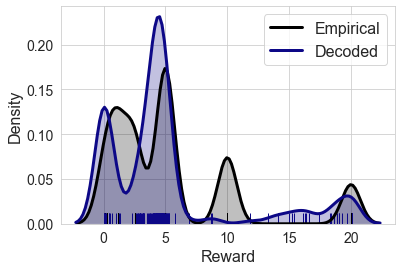

In [8]:
# Display kernel-density estimator and samples for ground truth and decoded
sns.set_style('whitegrid')
sns.kdeplot(sampled_empirical_dist, bw=.75, color='k', lw=3., shade=True, label="Empirical")
sns.rugplot(sampled_empirical_dist, color='k')

sns.kdeplot(reward_decode, bw=.75, color=plt.cm.plasma(0), lw=3., shade=True, label="Decoded")
sns.rugplot(reward_decode, color=plt.cm.plasma(0))

plt.tick_params(top=False, right=False, labelsize=14)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Reward", fontsize=16)
_ = plt.ylabel("Density", fontsize=16)

## Compare multiple decodings - Reward

In [9]:
n_trials = 10
n_epochs = 20000
num_cells = len(asym_values)
n_decodings = 5

# Global scale for learning rates, used by both simulations
beta = 0.5

In [10]:
# Compute variance in neural estimates to set level of noise for simulation
# Used in both simulations

model = sklearn.linear_model.LinearRegression(fit_intercept=True)
model.fit(expectile_values[:, None], asym_values[:, None])
asym_variance = (model.predict(expectile_values[:, None])[:, 0] - asym_values).std()

### Classic TD Simulation

In [11]:
# Classic TD simulation
td_values = np.zeros((n_trials, num_cells))
alpha = np.random.random(num_cells) * beta

for trial in range(n_trials):
  for step in range(n_epochs):
    # Sample reward
    reward = np.random.choice(juice_amounts, p=juice_empirical_probs)
    # Compute TD error
    delta = reward - td_values[trial]
    # Update value estimate
    td_values[trial] += alpha * delta


In [12]:
# Decoding from classic TD simulation
td_samples = []
td_losses = []
td_noise_samples = []

for t in range(n_decodings):
  # Add noise to the scaling, but have mean 0.5 giving symmetric updates
  scaling_noise = np.tanh(np.random.normal(size=len(alpha))) * asym_variance
  noisy_tau = np.clip(0.5 + scaling_noise, 0., 1.)
  td_noise_samples.append(noisy_tau)

  # Run decoding for classic TD
  values = run_decoding(
      td_values.mean(0), noisy_tau, 
      minv=juice_amounts.min(), maxv=juice_amounts.max(),
      max_epochs=1, N=len(asym_values)-1, max_samples=20000, method='TNC')

  td_samples.append(values[0])
  td_losses.append(values[1])
  print(t, values[1])

td_reward_decode = np.array(td_samples).flatten()

0 0.0006280598314989389
1 0.0015315543437722657
2 0.001250141965906342
3 0.0005671417342413385
4 0.0005941846252192658


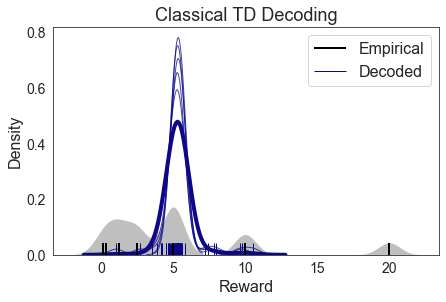

In [13]:
sns.set_style('white')
fig = plt.figure()
sns.kdeplot(sampled_empirical_dist, bw=.75, color='k', lw=0., shade=True)
sns.rugplot(sampled_empirical_dist, color='k', lw=2, zorder=10, label="Empirical")

sns.kdeplot(td_reward_decode, bw=.75, color=plt.cm.plasma(0), lw=4., zorder=5, shade=False)
sns.rugplot(td_reward_decode, color=plt.cm.plasma(0), label="Decoded")
for draw in td_samples:
  sns.kdeplot(draw, bw=.5, color=plt.cm.plasma(0.), alpha=.75, lw=1., shade=False)

plt.tick_params(top=False, right=False, labelsize=14)
plt.legend(loc="best", fontsize=16)
plt.xlabel("Reward", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Classical TD Decoding", fontsize=18)
plt.tight_layout(pad=0)


### Distributional TD Simulation

In [14]:
# Distributional TD simulation and decoding
distribution = np.zeros((n_trials, num_cells))
alpha_pos = np.random.random((num_cells))*beta
alpha_neg = np.random.random((num_cells))*beta

# Instead of sampling both randomly we could do
# (as is more common in AI agents):
# alpha_neg = beta - alpha_pos

for trial in range(n_trials):
  for step in range(n_epochs):
    # Sample reward
    reward = np.random.choice(juice_amounts, p=juice_empirical_probs)
    # Compute TD error
    delta = reward - distribution[trial]
    # Update distributional value estimate
    valence = np.array(delta <= 0., dtype=np.float32)
    distribution[trial] += (valence * alpha_neg + (1. - valence) * alpha_pos) * (delta)


In [15]:
# Decoding from distributional TD simulation
dtd_samples = []
dtd_losses = []
dtd_noise_samples = []
taus = alpha_pos / (alpha_pos + alpha_neg)

for t in range(n_decodings):
  # Add noise to the scaling, but have mean 0.5 giving symmetric updates
  scaling_noise = np.tanh(np.random.normal(size=len(taus))) * asym_variance
  noisy_tau = np.clip(taus + scaling_noise, 0., 1.)
  dtd_noise_samples.append(noisy_tau)

  # Run decoding for distributional TD
  values = run_decoding(
      distribution.mean(0), noisy_tau, 
      minv=juice_amounts.min(), maxv=juice_amounts.max(),
      max_epochs=1, N=len(asym_values)-1, max_samples=20000, method='TNC')

  dtd_samples.append(values[0])
  dtd_losses.append(values[1])
  print(t, values[1])

dtd_reward_decode = np.array(dtd_samples).flatten()

0 0.0457509308684924
1 0.03471890076586772
2 0.039744374147218334
3 0.04149335007736847
4 0.05270595826696698


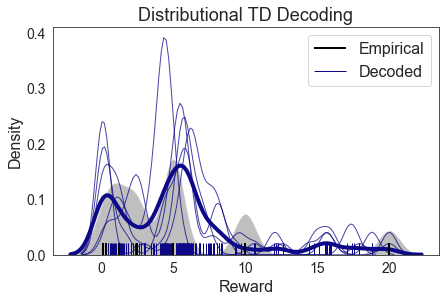

In [16]:
sns.set_style('white')
fig = plt.figure()
sns.kdeplot(sampled_empirical_dist, bw=.75, color='k', lw=0., shade=True)
sns.rugplot(sampled_empirical_dist, color='k', lw=2, zorder=10, label="Empirical")

sns.kdeplot(dtd_reward_decode, bw=.75, color=plt.cm.plasma(0), lw=4., zorder=5, shade=False)
sns.rugplot(dtd_reward_decode, color=plt.cm.plasma(0), label='Decoded')
for draw in dtd_samples:
  sns.kdeplot(draw, bw=.5, color=plt.cm.plasma(0.), alpha=.75, lw=1., shade=False)

plt.tick_params(top=False, right=False, labelsize=14)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Reward", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Distributional TD Decoding", fontsize=18)
plt.tight_layout(pad=0)


### Decoding from neural estimates

In [17]:
# Decoding from neural estimates
neural_samples = []
neural_losses = []

for t in range(n_decodings):
  # Run decoding for neural estimates
  values = run_decoding(
      expectile_values, asym_values,
      minv=juice_amounts.min(), maxv=juice_amounts.max(),
      max_epochs=1, N=len(asym_values)-1, max_samples=20000, method='TNC')

  neural_samples.append(values[0])
  neural_losses.append(values[1])
  print(t, values[1])

neural_reward_decode = np.array(neural_samples).flatten()

0 0.18976371542739356
1 0.1961590783376894
2 0.1910749282677459
3 0.21231152171596915
4 0.21486556257704156


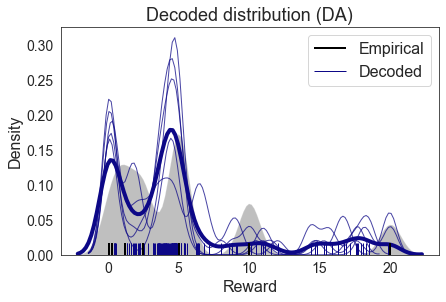

In [18]:
sns.set_style('white')
fig = plt.figure()
sns.kdeplot(sampled_empirical_dist, bw=.75, color='k', lw=0., shade=True)
sns.rugplot(sampled_empirical_dist, color='k', lw=2, zorder=10, label="Empirical")

sns.kdeplot(neural_reward_decode, bw=.75, color=plt.cm.plasma(0), lw=4., zorder=5, shade=False)
sns.rugplot(neural_reward_decode, color=plt.cm.plasma(0), label='Decoded')
for draw in neural_samples:
  sns.kdeplot(draw, bw=.5, color=plt.cm.plasma(0.), alpha=.75, lw=1., shade=False)

plt.tick_params(top=False, right=False, labelsize=14)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Reward", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Decoded distribution (DA)", fontsize=18)
plt.tight_layout(pad=0)


## Sensitivity of decoding loss to reference distributions - Reward 

In [19]:
def leave_one_out(values, i):
  return np.hstack([values[:i], values[i+1:]])

In [20]:
# Predefined reference distributions (ground truth, uniform, gaussian, mirror)
empirical_mean = np.dot(juice_amounts, juice_empirical_probs)
empirical_std = np.sqrt(np.dot(
    (juice_amounts - empirical_mean)**2., juice_empirical_probs))

N = 50000
many_reward_subsamples = np.random.choice(
    juice_amounts, p=juice_empirical_probs, size=(len(asym_values), N))

ground_truth_loss = np.zeros(len(asym_values))
mirror_truth_loss = np.zeros(len(asym_values))
uniform_loss = np.zeros(len(asym_values))
gaussian_loss = np.zeros(len(asym_values))

for (i, d) in enumerate(many_reward_subsamples):
  values, scales = expectile_values, asym_values

  # Comment out to use leave-one-out cross-validation over cells
  # Does not fundamentally change results
  # values, scales = leave_one_out(expectile_values, i), leave_one_out(asym_values, i)

  # Ground truth
  ground_truth_loss[i] = expectile_loss_fn(values, scales, d)

  # Mirror ground truth distribution, and clip to reasonable range
  mirror = (d - d.mean())*-1 + d.mean()
  mirror_truth_loss[i] = expectile_loss_fn(values, scales, mirror)
  
  # Uniform
  unif_d = np.clip(
      2*(np.random.random(size=N) - 0.5) * empirical_std + empirical_mean,
      juice_amounts.min(), juice_amounts.max())
  uniform_loss[i] = expectile_loss_fn(values, scales, unif_d)

  # Gaussian
  gauss_d = np.random.normal(empirical_mean, scale=empirical_std, size=N)
  gaussian_loss[i] = expectile_loss_fn(values, scales, gauss_d)


In [21]:
# Effects of perturbing mean and variance of ground truth distribution

# These values were hand-chosen to give a comparable
# range of losses as the above reference distributions.
shifts = np.linspace(0., 1.0, 50)
mult = np.linspace(1., 1.75, 100)
div = np.linspace(1., 0.25, 100)

## Shifting the mean of the ground truth distribution
subsamples = np.random.choice(
    juice_amounts, p=juice_empirical_probs, size=(len(shifts), N))
mean_neg_loss = np.zeros(len(shifts))
mean_pos_loss = np.zeros(len(shifts))

for (i, d) in enumerate(subsamples):
  values, scales = expectile_values, asym_values
  mean_neg_loss[i] = expectile_loss_fn(values, scales, d - shifts[i]) 
  mean_pos_loss[i] = expectile_loss_fn(values, scales, d + shifts[i]) 

## Perturbing the variance of the ground truth distribution
subsamples = np.random.choice(
    juice_amounts, p=juice_empirical_probs, size=(len(mult), N))
var_neg_loss = np.zeros(len(mult))
var_pos_loss = np.zeros(len(mult))

for (i, d) in enumerate(subsamples):
  values, scales = expectile_values, asym_values
  var_neg_loss[i] = expectile_loss_fn(values, scales, 
                                      (d - d.mean()) * div[i] + d.mean()) 
  var_pos_loss[i] = expectile_loss_fn(values, scales, 
                                      (d - d.mean()) * mult[i] + d.mean())


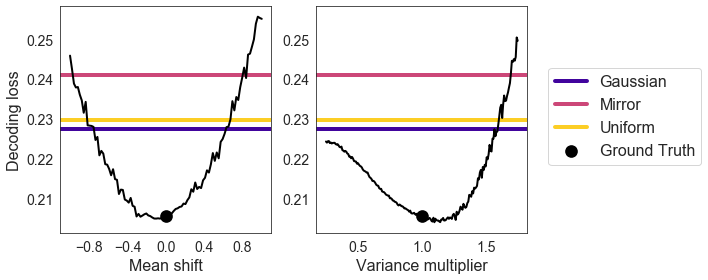

In [22]:
fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

# Plot reference distributions' losses
plt.axhline(gaussian_loss.mean(), color=plt.cm.plasma(0.1), lw=4, zorder=0)
plt.axhline(mirror_truth_loss.mean(), color=plt.cm.plasma(0.5), lw=4, zorder=0)
plt.axhline(uniform_loss.mean(), color=plt.cm.plasma(.9), lw=4, zorder=0)

# Plot loss as we shift the ground truth distribution's mean
plt.plot(np.zeros_like(mean_neg_loss) - shifts, mean_neg_loss, color='k', lw=2)
plt.plot(np.zeros_like(mean_pos_loss) + shifts, mean_pos_loss, color='k', lw=2)

# Plot loss of ground truth distribution
plt.scatter(0., ground_truth_loss.mean(), c='k', s=160, lw=0, zorder=10)

plt.xticks([-.8, -.4, 0., .4, .8])
plt.tick_params(top=False, right=False, labelsize=14)
plt.xlabel("Mean shift", fontsize=16)
plt.ylabel("Decoding loss", fontsize=16)
ylim = plt.ylim()

plt.subplot(1, 2, 2)

# Plot reference distributions' losses
plt.axhline(gaussian_loss.mean(), color=plt.cm.plasma(0.1), lw=4, zorder=0, label="Gaussian")
plt.axhline(mirror_truth_loss.mean(), color=plt.cm.plasma(0.5), lw=4, zorder=0, label="Mirror")
plt.axhline(uniform_loss.mean(), color=plt.cm.plasma(.9), lw=4, zorder=0, label="Uniform")

# Plot loss as we shift the ground truth distribution's variance
plt.plot(np.zeros_like(var_neg_loss) + div, var_neg_loss, color='k', lw=2)
plt.plot(np.zeros_like(var_pos_loss) + mult, var_pos_loss, color='k', lw=2)

# Plot loss of ground truth distribution
plt.scatter(1., ground_truth_loss.mean(), c='k', s=160, lw=0, zorder=10, label="Ground Truth")

plt.ylim(ylim)
plt.tick_params(top=False, right=False, labelsize=14)
plt.xlabel("Variance multiplier", fontsize=16)
plt.legend(loc=(1.1, 0.3), fontsize=16)

plt.tight_layout()


## Sensitivity of decoding loss to distribution - Reward (interpolating decoded -> ground truth -> Gaussian)

In [23]:
# Experiment setup
n_trials = 100
n_interp = 10
n_samples = 2000

# Compute empirical mean and standard deviation for Gaussian
empirical_mean = np.dot(juice_amounts, juice_empirical_probs)
empirical_std = np.sqrt(np.dot(
    (juice_amounts - empirical_mean)**2., juice_empirical_probs))

x_interp = np.linspace(0., 1., n_interp)
loss_scores = np.zeros((n_trials, n_interp*2))
loss_dists = np.zeros((n_interp*2, n_trials, n_samples))

# Interpolate between decoded distribution and empirical distribution
sample_0 = lambda: np.random.choice(reward_decode)
sample_1 = lambda: np.random.choice(juice_amounts, p=juice_empirical_probs)
for i, x in enumerate(x_interp):
  for t in range(n_trials):
    dist = np.random.choice([True, False], p=[1. - x, x], size=n_samples)
    dist = np.array([sample_0() if q else sample_1() for q in dist])
    loss_dists[i, t] = dist
    loss_scores[t, i] = expectile_loss_fn(expectile_values, asym_values, dist)

# Interpolate between empirical distribution and empirical Gaussian
sample_2 = lambda: np.random.normal(empirical_mean, empirical_std)
for i, x in enumerate(x_interp):
  i += n_interp
  for t in range(n_trials):
    dist = np.random.choice([True, False], p=[1. - x, x], size=n_samples)
    dist = np.array([sample_1() if q else sample_2() for q in dist])
    loss_dists[i, t] = dist
    loss_scores[t, i] = expectile_loss_fn(expectile_values, asym_values, dist)

x_interp = np.hstack([x_interp, x_interp + 1.])
# Combine trials for distributions (averaging would bias distribution)
loss_dists = loss_dists.reshape((n_interp * 2, -1))


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and t

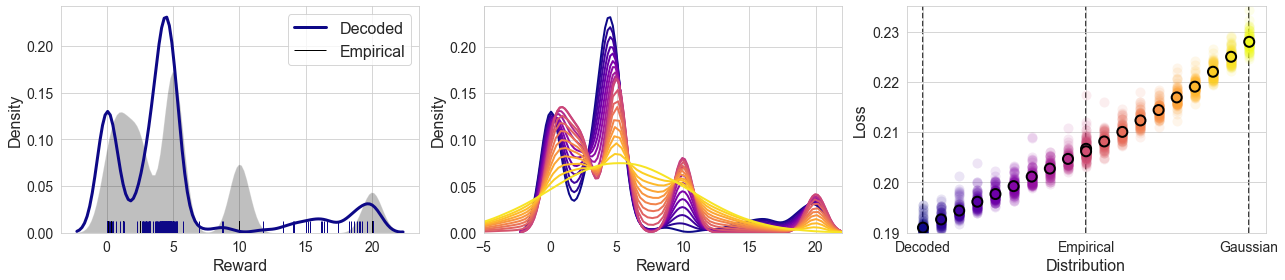

In [24]:
cmap = plt.cm.plasma
sns.set_style('whitegrid')
fig = plt.figure(figsize=(18, 4))

# Plot the decoded distribution vs. empirical
plt.subplot(1, 3, 1)
sns.kdeplot(sampled_empirical_dist, bw=.75, color='k', lw=0., shade=True)
sns.rugplot(sampled_empirical_dist, color='k', label="Empirical")

sns.kdeplot(reward_decode, bw=.75, color=cmap(0.), lw=3.,
            shade=False, label="Decoded")
sns.rugplot(reward_decode, color=cmap(0.))

plt.ylabel("Density", fontsize=16)
plt.xlabel("Reward", fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tick_params(top=False, right=False, labelsize=14)

# For each interpolating reference distribution
# plot the distribution itself and the loss it produces
for s in range(loss_dists.shape[0]):
  plt.subplot(1, 3, 2)
  sns.kdeplot(loss_dists[s, :], bw=.75, lw=2,
              color=cmap(float(s)/loss_dists.shape[0]))
  plt.tick_params(top=False, right=False, labelsize=14)

  plt.subplot(1, 3, 3)
  plt.scatter(np.ones_like(loss_scores[:, 0])*x_interp[s], loss_scores[:, s],
              c=cmap(np.linspace(0., 1., loss_dists.shape[0])[s]),
              s=100, lw=0, alpha=0.1)

# Plot means over trials for loss evaluations
plt.subplot(1, 3, 3)
plt.scatter(x_interp, loss_scores.mean(0),
            c=cmap(np.linspace(0., 1., loss_dists.shape[0])),
            s=100, lw=2, edgecolor='k')

plt.tick_params(top=False, right=False, labelsize=14)
# Tightly cropping around results (may need to change if decoding is different)
plt.xlim([-.1, 2.1])
plt.ylim([0.19, 0.235])
plt.yticks(np.linspace(0.19, 0.23, 5))

# Additional annotation and visualization details
plt.axvline(0, linestyle='--', color='k', zorder=0)
plt.axvline(1., linestyle='--', color='k', zorder=0)
plt.axvline(2., linestyle='--', color='k', zorder=0)
_ = plt.xticks(np.arange(3), ["Decoded", "Empirical", "Gaussian"], fontsize=14)
plt.xlabel("Distribution", fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.subplot(1, 3, 2)
plt.xlim([-5, 22.])
plt.xlabel("Reward", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.tight_layout()


## Sensitivity of decoding loss to pairing of reversal-points and asymmetries - Reward

In [25]:
# Note: This experiment can take some time due to running so many decodings

# How many shifts of the asymmetries to consider
n_steps = 31

# Shifting values should respect the range of a gaussian:
# [-3, 3] covers a very wide range of transforms
shifts = np.linspace(-3, 3, n_steps)

# How many decoded samples
n_decode = len(asym_values)-1

correlation_samples = np.zeros((n_steps, n_decode))
correlation_taus = np.zeros((n_steps, len(expectile_values)))
correlation_fvals = np.zeros(n_steps)
tau_dict = {'shift': [], 'loss': []}

for step in range(n_steps):
  # Skew the asymmetric scaling with a monotonic function
  shift = shifts[step]
  new_taus = scipy.stats.norm.cdf(scipy.stats.norm.ppf(asym_values) + shift)
  # Decode with estimated reversal points, but skewed asymmetries
  samples, fvl = run_decoding(
      expectile_values, new_taus, minv=0.0, maxv=juice_amounts.max(),
      max_epochs=1, N=len(asym_values)-1, max_samples=20000, method='TNC')

  correlation_samples[step] = samples
  correlation_taus[step] = new_taus
  correlation_fvals[step] = expectile_loss_fn(
      expectile_values, new_taus, sampled_empirical_dist)

  tau_dict['shift'].append(shift)
  tau_dict['loss'].append(correlation_fvals[step])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

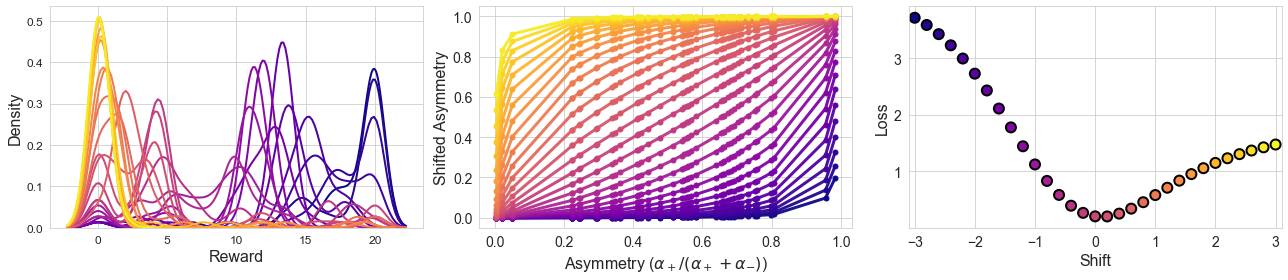

In [26]:
cmap = plt.cm.plasma
fig = plt.figure(figsize=(18, 4))

# Looping over the different shifts applied
for s in range(n_steps):
  # Plot the decoded distribution for this transformation of the asymmetries
  plt.subplot(1, 3, 1)
  sns.kdeplot(correlation_samples[s, :], bw=.75, lw=2, color=cmap(float(s)/n_steps))
  plt.tick_params(top=False, right=False, labelsize=12)

  # Plot the transformation itself, that is:
  # shifted asymmetry w.r.t. original asymmetry
  plt.subplot(1, 3, 2)
  ind = np.argsort(asym_values)
  plt.plot(asym_values[ind], correlation_taus[s][ind],
           color=cmap(float(s)/n_steps), lw=3., alpha=0.95)
  plt.plot(asym_values[ind], correlation_taus[s][ind], '.',
           color=cmap(float(s)/n_steps), markersize=10)
  plt.tick_params(top=False, right=False, labelsize=12)


plt.subplot(1, 3, 1)
plt.xlabel("Reward", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.subplot(1, 3, 2)
plt.ylabel("Shifted Asymmetry", fontsize=16)
plt.xlabel("Asymmetry ($\\alpha_+ / (\\alpha_+ + \\alpha_{-})$)", fontsize=16)
plt.tick_params(top=False, right=False, labelsize=14)

# Plot the loss function evaluated for these various decodings
plt.subplot(1, 3, 3)
plt.scatter(shifts, correlation_fvals, c=cmap(np.linspace(0., 1., n_steps)),
            s=100, lw=2, edgecolor='k')
plt.tick_params(top=False, right=False, labelsize=14)
plt.xlim([-3.1, 3.1])
plt.xlabel("Shift", fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.tight_layout()

## Compare multiple decodings - Utility

In [27]:
n_trials = 10
n_epochs = 20000
num_cells = len(asym_values)
n_decodings = 5

# Global scale for learning rates, used by both simulations
beta = 0.5

util_empirical_dist = np.random.choice(
    juice_util, p=juice_empirical_probs, size=1000)

In [28]:
# Compute variance in neural estimates to set level of noise for simulation
# Used in both simulations

model = sklearn.linear_model.LinearRegression(fit_intercept=True)
model.fit(util_expectile_values[:, None], util_asym_values[:, None])
util_asym_variance = (model.predict(util_expectile_values[:, None])[:, 0] - util_asym_values).std()

### Classic TD Simulation

In [29]:
# Classic TD simulation
td_values = np.zeros((n_trials, num_cells))
alpha = np.random.random(num_cells) * beta

for trial in range(n_trials):
  for step in range(n_epochs):
    # Sample reward
    reward = np.random.choice(juice_util, p=juice_empirical_probs)
    # Compute TD error
    delta = reward - td_values[trial]
    # Update value estimate
    td_values[trial] += alpha * delta


In [30]:
# Decoding from classic TD simulation
td_util_samples = []
td_losses = []
td_noise_samples = []

for t in range(n_decodings):
  # Add noise to the scaling, but have mean 0.5 giving symmetric updates
  scaling_noise = np.tanh(np.random.normal(size=len(alpha))) * util_asym_variance
  noisy_tau = np.clip(0.5 + scaling_noise, 0., 1.)
  td_noise_samples.append(noisy_tau)

  # Run decoding for classic TD
  values = run_decoding(
      td_values.mean(0), noisy_tau, 
      minv=juice_util.min(), maxv=juice_util.max(),
      max_epochs=1, N=len(asym_values)-1, max_samples=20000, method='TNC')

  td_util_samples.append(values[0])
  td_losses.append(values[1])
  print(t, values[1])

td_util_decode = np.array(td_util_samples).flatten()

0 0.003026163231164871
1 0.0032059333501919655
2 0.0033431199862167553
3 0.0026931568565562733
4 0.0033043172041106544


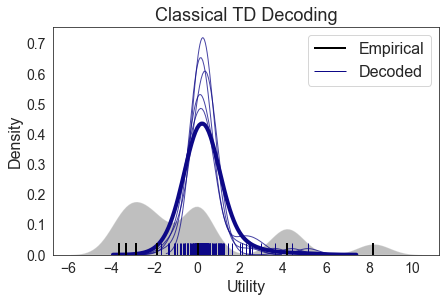

In [31]:
sns.set_style('white')
fig = plt.figure()
sns.kdeplot(util_empirical_dist, bw=.75, color='k', lw=0., shade=True)
sns.rugplot(util_empirical_dist, color='k', lw=2, zorder=10, label="Empirical")

sns.kdeplot(td_util_decode, bw=.75, color=plt.cm.plasma(0), lw=4., zorder=5, shade=False)
sns.rugplot(td_util_decode, color=plt.cm.plasma(0), label="Decoded")
for draw in td_util_samples:
  sns.kdeplot(draw, bw=.5, color=plt.cm.plasma(0.), alpha=.75, lw=1., shade=False)

plt.tick_params(top=False, right=False, labelsize=14)
plt.legend(loc="best", fontsize=16)
plt.xlabel("Utility", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Classical TD Decoding", fontsize=18)
plt.tight_layout(pad=0)


### Distributional TD Simulation

In [32]:
# Distributional TD simulation and decoding
distribution = np.zeros((n_trials, num_cells))
alpha_pos = np.random.random((num_cells))*beta
alpha_neg = np.random.random((num_cells))*beta

# Instead of sampling both randomly we could do
# (as is more common in AI agents):
# alpha_neg = beta - alpha_pos

for trial in range(n_trials):
  for step in range(n_epochs):
    # Sample reward
    reward = np.random.choice(juice_util, p=juice_empirical_probs)
    # Compute TD error
    delta = reward - distribution[trial]
    # Update distributional value estimate
    valence = np.array(delta <= 0., dtype=np.float32)
    distribution[trial] += (valence * alpha_neg + (1. - valence) * alpha_pos) * (delta)


In [33]:
# Decoding from distributional TD simulation
dtd_util_samples = []
dtd_losses = []
dtd_noise_samples = []
taus = alpha_pos / (alpha_pos + alpha_neg)

for t in range(n_decodings):
  # Add noise to the scaling, but have mean 0.5 giving symmetric updates
  scaling_noise = np.tanh(np.random.normal(size=len(taus))) * util_asym_variance
  noisy_tau = np.clip(taus + scaling_noise, 0., 1.)
  dtd_noise_samples.append(noisy_tau)

  # Run decoding for distributional TD
  values = run_decoding(
      distribution.mean(0), noisy_tau, 
      minv=juice_util.min(), maxv=juice_util.max(),
      max_epochs=1, N=len(util_asym_values)-1, max_samples=20000, method='TNC')

  dtd_util_samples.append(values[0])
  dtd_losses.append(values[1])
  print(t, values[1])

dtd_util_decode = np.array(dtd_util_samples).flatten()

0 0.014666278472777688
1 0.008066145225107943
2 0.007536458014359364
3 0.011910392642763475
4 0.009564670890927683


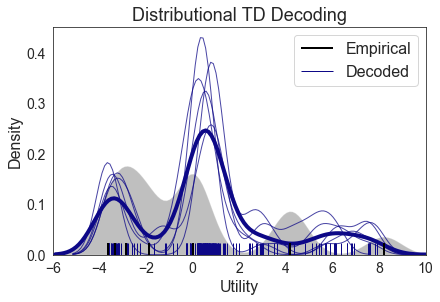

In [34]:
sns.set_style('white')
fig = plt.figure()
sns.kdeplot(util_empirical_dist, bw=.75, color='k', lw=0., shade=True)
sns.rugplot(util_empirical_dist, color='k', lw=2, zorder=10, label="Empirical")

sns.kdeplot(dtd_util_decode, bw=.75, color=plt.cm.plasma(0), lw=4., zorder=5, shade=False)
sns.rugplot(dtd_util_decode, color=plt.cm.plasma(0), label='Decoded')
for draw in dtd_util_samples:
  sns.kdeplot(draw, bw=.5, color=plt.cm.plasma(0.), alpha=.75, lw=1., shade=False)

plt.xlim([-6., 10.])
plt.tick_params(top=False, right=False, labelsize=14)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Utility", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Distributional TD Decoding", fontsize=18)
plt.tight_layout(pad=0)


### Decoding from neural estimates

In [35]:
# Decoding from neural estimates
neural_util_samples = []
neural_losses = []

for t in range(n_decodings):
  # Run decoding for neural estimates
  values = run_decoding(
      util_expectile_values, util_asym_values,
      minv=juice_util.min(), maxv=juice_util.max(),
      max_epochs=1, N=len(asym_values)-1, max_samples=20000, method='TNC')

  neural_util_samples.append(values[0])
  neural_losses.append(values[1])
  print(t, values[1])

neural_util_decode = np.array(neural_util_samples).flatten()

0 0.058516222299362
1 0.06412459498202508
2 0.060790391884379555
3 0.05854240619343731
4 0.05909811261966904


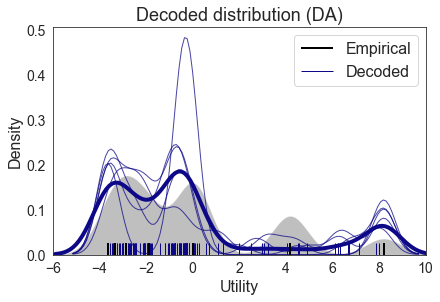

In [36]:
sns.set_style('white')
fig = plt.figure()
sns.kdeplot(util_empirical_dist, bw=.75, color='k', lw=0., shade=True)
sns.rugplot(util_empirical_dist, color='k', lw=2, zorder=10, label="Empirical")

sns.kdeplot(neural_util_decode, bw=.75, color=plt.cm.plasma(0), lw=4., zorder=5, shade=False)
sns.rugplot(neural_util_decode, color=plt.cm.plasma(0), label='Decoded')
for draw in neural_util_samples:
  sns.kdeplot(draw, bw=.5, color=plt.cm.plasma(0.), alpha=.75, lw=1., shade=False)

plt.xlim([-6., 10.])
plt.tick_params(top=False, right=False, labelsize=14)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Utility", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Decoded distribution (DA)", fontsize=18)
plt.tight_layout(pad=0)


## Sensitivity of decoding loss to reference distributions - Utility 

In [37]:
def leave_one_out(values, i):
  return np.hstack([values[:i], values[i+1:]])

In [38]:
# Predefined reference distributions (ground truth, uniform, gaussian, mirror)
empirical_mean = np.dot(juice_util, juice_empirical_probs)
empirical_std = np.sqrt(np.dot(
    (juice_util - empirical_mean)**2., juice_empirical_probs))

N = 50000
many_reward_subsamples = np.random.choice(
    juice_util, p=juice_empirical_probs, size=(len(asym_values), N))

ground_truth_loss = np.zeros(len(asym_values))
mirror_truth_loss = np.zeros(len(asym_values))
uniform_loss = np.zeros(len(asym_values))
gaussian_loss = np.zeros(len(asym_values))

for (i, d) in enumerate(many_reward_subsamples):
  values, scales = util_expectile_values, util_asym_values

  # Comment out to use leave-one-out cross-validation over cells
  # Does not fundamentally change results
  # values, scales = leave_one_out(util_expectile_values, i), leave_one_out(util_asym_values, i)

  # Ground truth
  ground_truth_loss[i] = expectile_loss_fn(values, scales, d)

  # Mirror ground truth distribution, and clip to reasonable range
  mirror = (d - d.mean())*-1 + d.mean()
  mirror_truth_loss[i] = expectile_loss_fn(values, scales, mirror)
  
  # Uniform
  unif_d = np.clip(
      2*(np.random.random(size=N) - 0.5) * empirical_std + empirical_mean,
      juice_util.min(), juice_util.max())
  uniform_loss[i] = expectile_loss_fn(values, scales, unif_d)

  # Gaussian
  gauss_d = np.random.normal(empirical_mean, scale=empirical_std, size=N)
  gaussian_loss[i] = expectile_loss_fn(values, scales, gauss_d)


In [39]:
# Effects of perturbing mean and variance of ground truth distribution

# These values were hand-chosen to give a comparable
# range of losses as the above reference distributions.
shifts = np.linspace(0., 0.8, 50)
mult = np.linspace(1., 2., 100)
div = np.linspace(1., 0.25, 100)

## Shifting the mean of the ground truth distribution
subsamples = np.random.choice(
    juice_util, p=juice_empirical_probs, size=(len(shifts), N))
mean_neg_loss = np.zeros(len(shifts))
mean_pos_loss = np.zeros(len(shifts))

for (i, d) in enumerate(subsamples):
  values, scales = util_expectile_values, util_asym_values
  mean_neg_loss[i] = expectile_loss_fn(values, scales, d - shifts[i]) 
  mean_pos_loss[i] = expectile_loss_fn(values, scales, d + shifts[i]) 

## Perturbing the variance of the ground truth distribution
subsamples = np.random.choice(
    juice_util, p=juice_empirical_probs, size=(len(mult), N))
var_neg_loss = np.zeros(len(mult))
var_pos_loss = np.zeros(len(mult))

for (i, d) in enumerate(subsamples):
  values, scales = util_expectile_values, util_asym_values
  var_neg_loss[i] = expectile_loss_fn(values, scales, 
                                      (d - d.mean()) * div[i] + d.mean()) 
  var_pos_loss[i] = expectile_loss_fn(values, scales, 
                                      (d - d.mean()) * mult[i] + d.mean())


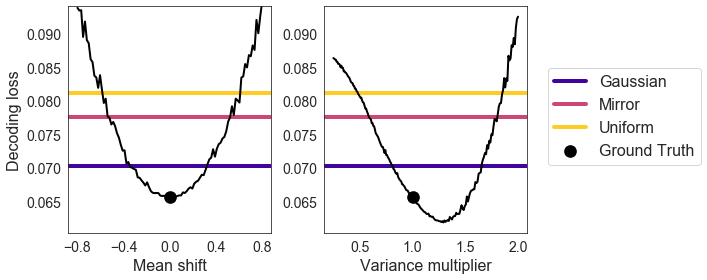

In [40]:
fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 2)
# Plot reference distributions' losses
plt.axhline(gaussian_loss.mean(), color=plt.cm.plasma(0.1), lw=4, zorder=0, label="Gaussian")
plt.axhline(mirror_truth_loss.mean(), color=plt.cm.plasma(0.5), lw=4, zorder=0, label="Mirror")
plt.axhline(uniform_loss.mean(), color=plt.cm.plasma(.9), lw=4, zorder=0, label="Uniform")

# Plot loss as we shift the ground truth distribution's variance
plt.plot(np.zeros_like(var_neg_loss) + div, var_neg_loss, color='k', lw=2)
plt.plot(np.zeros_like(var_pos_loss) + mult, var_pos_loss, color='k', lw=2)

# Plot loss of ground truth distribution
plt.scatter(1., ground_truth_loss.mean(), c='k', s=160, lw=0, zorder=10, label="Ground Truth")

ylim = plt.ylim()
plt.tick_params(top=False, right=False, labelsize=14)
plt.xlabel("Variance multiplier", fontsize=16)
plt.legend(loc=(1.1, 0.3), fontsize=16)

plt.subplot(1, 2, 1)
# Plot reference distributions' losses
plt.axhline(gaussian_loss.mean(), color=plt.cm.plasma(0.1), lw=4, zorder=0)
plt.axhline(mirror_truth_loss.mean(), color=plt.cm.plasma(0.5), lw=4, zorder=0)
plt.axhline(uniform_loss.mean(), color=plt.cm.plasma(.9), lw=4, zorder=0)

# Plot loss as we shift the ground truth distribution's mean
plt.plot(np.zeros_like(mean_neg_loss) - shifts, mean_neg_loss, color='k', lw=2)
plt.plot(np.zeros_like(mean_pos_loss) + shifts, mean_pos_loss, color='k', lw=2)

# Plot loss of ground truth distribution
plt.scatter(0., ground_truth_loss.mean(), c='k', s=160, lw=0, zorder=10)

plt.ylim(ylim)
plt.xticks([-.8, -.4, 0., .4, .8])
plt.tick_params(top=False, right=False, labelsize=14)
plt.xlabel("Mean shift", fontsize=16)
plt.ylabel("Decoding loss", fontsize=16)

plt.tight_layout()

## Sensitivity of decoding loss to distribution - Utility (interpolating decoded -> ground truth -> Gaussian)

In [41]:
# Experiment setup
n_trials = 100
n_interp = 10
n_samples = 2000

# Compute empirical mean and standard deviation for Gaussian
empirical_mean = np.dot(juice_util, juice_empirical_probs)
empirical_std = np.sqrt(np.dot(
    (juice_util - empirical_mean)**2., juice_empirical_probs))

x_interp = np.linspace(0., 1., n_interp)
loss_scores = np.zeros((n_trials, n_interp*2))
loss_dists = np.zeros((n_interp*2, n_trials, n_samples))

# Interpolate between decoded distribution and empirical distribution
sample_0 = lambda: np.random.choice(neural_util_decode)
sample_1 = lambda: np.random.choice(juice_util, p=juice_empirical_probs)
for i, x in enumerate(x_interp):
  for t in range(n_trials):
    dist = np.random.choice([True, False], p=[1. - x, x], size=n_samples)
    dist = np.array([sample_0() if q else sample_1() for q in dist])
    loss_dists[i, t] = dist
    loss_scores[t, i] = expectile_loss_fn(util_expectile_values, util_asym_values, dist)

# Interpolate between empirical distribution and empirical Gaussian
sample_2 = lambda: np.random.normal(empirical_mean, empirical_std)
for i, x in enumerate(x_interp):
  i += n_interp
  for t in range(n_trials):
    dist = np.random.choice([True, False], p=[1. - x, x], size=n_samples)
    dist = np.array([sample_1() if q else sample_2() for q in dist])
    loss_dists[i, t] = dist
    loss_scores[t, i] = expectile_loss_fn(util_expectile_values, util_asym_values, dist)

x_interp = np.hstack([x_interp, x_interp + 1.])
# Combine trials for distributions (averaging would bias distribution)
loss_dists = loss_dists.reshape((n_interp * 2, -1))


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and t

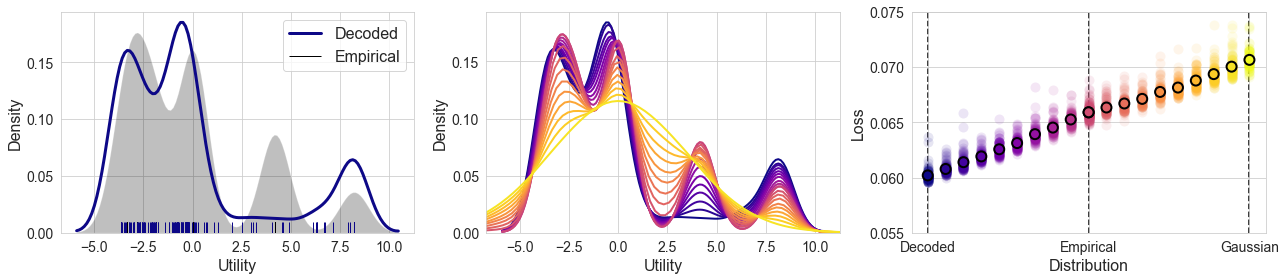

In [42]:
cmap = plt.cm.plasma
sns.set_style('whitegrid')
fig = plt.figure(figsize=(18, 4))

# Plot the decoded distribution vs. empirical
plt.subplot(1, 3, 1)
sns.kdeplot(util_empirical_dist, bw=.75, color='k', lw=0., shade=True)
sns.rugplot(util_empirical_dist, color='k', label="Empirical")

sns.kdeplot(neural_util_decode, bw=.75, color=cmap(0.), lw=3.,
            shade=False, label="Decoded")
sns.rugplot(neural_util_decode, color=cmap(0.))

xlim = plt.xlim()
plt.ylabel("Density", fontsize=16)
plt.xlabel("Utility", fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tick_params(top=False, right=False, labelsize=14)

# For each interpolating reference distribution
# plot the distribution itself and the loss it produces
for s in range(loss_dists.shape[0]):
  plt.subplot(1, 3, 2)
  sns.kdeplot(loss_dists[s, :], bw=.75, lw=2,
              color=cmap(float(s)/loss_dists.shape[0]))
  plt.tick_params(top=False, right=False, labelsize=14)

  plt.subplot(1, 3, 3)
  plt.scatter(np.ones_like(loss_scores[:, 0])*x_interp[s], loss_scores[:, s],
              c=cmap(np.linspace(0., 1., loss_dists.shape[0])[s]),
              s=100, lw=0, alpha=0.1)

# Plot means over trials for loss evaluations
plt.subplot(1, 3, 3)
plt.scatter(x_interp, loss_scores.mean(0),
            c=cmap(np.linspace(0., 1., loss_dists.shape[0])),
            s=100, lw=2, edgecolor='k')

plt.tick_params(top=False, right=False, labelsize=14)
# Tightly cropping around results (may need to change if decoding is different)
plt.xlim([-.1, 2.1])
plt.ylim([0.055, 0.075])

# Additional annotation and visualization details
plt.axvline(0, linestyle='--', color='k', zorder=0)
plt.axvline(1., linestyle='--', color='k', zorder=0)
plt.axvline(2., linestyle='--', color='k', zorder=0)
_ = plt.xticks(np.arange(3), ["Decoded", "Empirical", "Gaussian"], fontsize=14)
plt.xlabel("Distribution", fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.subplot(1, 3, 2)
plt.xlim(xlim)
plt.xlabel("Utility", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.tight_layout()


## Sensitivity of decoding loss to pairing of reversal-points and asymmetries - Utility

In [43]:
# Note: This experiment can take some time due to running so many decodings

# How many shifts of the asymmetries to consider
n_steps = 31

# Shifting values should respect the range of a gaussian:
# [-3, 3] covers a very wide range of transforms
shifts = np.linspace(-3, 3, n_steps)

# How many decoded samples
n_decode = len(util_asym_values)-1

correlation_samples = np.zeros((n_steps, n_decode))
correlation_taus = np.zeros((n_steps, len(util_expectile_values)))
correlation_fvals = np.zeros(n_steps)
tau_dict = {'shift': [], 'loss': []}

for step in range(n_steps):
  # Skew the asymmetric scaling with a monotonic function
  shift = shifts[step]
  new_taus = scipy.stats.norm.cdf(scipy.stats.norm.ppf(util_asym_values) + shift)
  # Decode with estimated reversal points, but skewed asymmetries
  samples, fvl = run_decoding(
      util_expectile_values, new_taus, minv=juice_util.min(), maxv=juice_util.max(),
      max_epochs=1, N=len(util_asym_values)-1, max_samples=20000, method='TNC')

  correlation_samples[step] = samples
  correlation_taus[step] = new_taus
  correlation_fvals[step] = expectile_loss_fn(
      util_expectile_values, new_taus, util_empirical_dist)

  tau_dict['shift'].append(shift)
  tau_dict['loss'].append(correlation_fvals[step])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

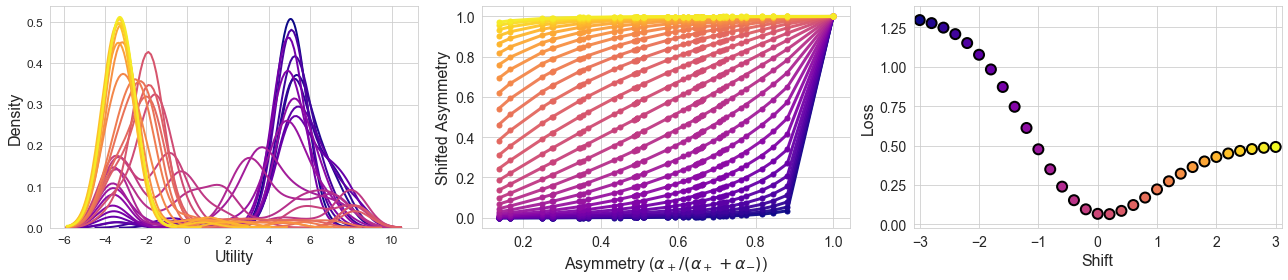

In [44]:
cmap = plt.cm.plasma
fig = plt.figure(figsize=(18, 4))

# Looping over the different shifts applied
for s in range(n_steps):
  # Plot the decoded distribution for this transformation of the asymmetries
  plt.subplot(1, 3, 1)
  sns.kdeplot(correlation_samples[s, :], bw=.75, lw=2, color=cmap(float(s)/n_steps))
  plt.tick_params(top=False, right=False, labelsize=12)

  # Plot the transformation itself, that is:
  # shifted asymmetry w.r.t. original asymmetry
  plt.subplot(1, 3, 2)
  ind = np.argsort(util_asym_values)
  plt.plot(util_asym_values[ind], correlation_taus[s][ind],
           color=cmap(float(s)/n_steps), lw=3., alpha=0.95)
  plt.plot(util_asym_values[ind], correlation_taus[s][ind], '.',
           color=cmap(float(s)/n_steps), markersize=10)
  plt.tick_params(top=False, right=False, labelsize=12)


plt.subplot(1, 3, 1)
plt.xlabel("Utility", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.subplot(1, 3, 2)
plt.ylabel("Shifted Asymmetry", fontsize=16)
plt.xlabel("Asymmetry ($\\alpha_+ / (\\alpha_+ + \\alpha_{-})$)", fontsize=16)
plt.tick_params(top=False, right=False, labelsize=14)

# Plot the loss function evaluated for these various decodings
plt.subplot(1, 3, 3)
plt.scatter(shifts, correlation_fvals, c=cmap(np.linspace(0., 1., n_steps)),
            s=100, lw=2, edgecolor='k')
plt.tick_params(top=False, right=False, labelsize=14)
plt.xlim([-3.1, 3.1])
plt.xlabel("Shift", fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.tight_layout()

# Variable-probability experiment

## Load processed data (variable-probability task)

In [45]:
da_data = np.array([[ 0.25163145,  0.31350325,  0.98764104],
                    [ 0.39567073,  0.1666229 ,  0.9598609 ],
                    [ 0.17267129,  0.40723317,  0.96725242],
                    [ 0.2538857 ,  0.29969001,  0.98278111],
                    [ 0.11620758,  0.41003734,  0.92285578],
                    [ 0.14609846,  0.38811597,  0.94243724],
                    [ 0.24601418,  0.28183428,  0.97035023],
                    [ 0.23239447,  0.31108242,  0.97555387],
                    [ 0.2246324 ,  0.25072338,  0.94442356],
                    [ 0.16069077,  0.38865371,  0.95366022],
                    [ 0.10890081,  0.47782808,  0.92417305],
                    [ 0.09925889,  0.49327081,  0.91559186],
                    [ 0.08930579,  0.49634832,  0.90580119],
                    [ 0.13563566,  0.44477471,  0.94467046],
                    [ 0.10135619,  0.4975654 ,  0.91773557],
                    [ 0.05452662,  0.51840051,  0.86837057],
                    [ 0.07777134,  0.54443981,  0.89133433],
                    [ 0.01519776,  0.53433635,  0.82054296],
                    [ 0.07437405,  0.50664613,  0.89038978],
                    [ 0.07241413,  0.55033262,  0.88469304],
                    [ 0.03962269,  0.56116796,  0.84444762],
                    [ 0.06680219,  0.56293081,  0.87646449],
                    [ 0.05347323,  0.6627771 ,  0.82882847],
                    [ 0.04930061,  0.59634158,  0.84775884],
                    [ 0.05795735,  0.63880991,  0.84533204],
                    [ 0.04948719,  0.57972323,  0.85232011],
                    [ 0.04992605,  0.57647127,  0.85362682],
                    [ 0.04937227,  0.60788653,  0.84442622],
                    [ 0.04917193,  0.680548  ,  0.81321607],
                    [ 0.0220474 ,  0.66754662,  0.77780747],
                    [ 0.0455529 ,  0.66769289,  0.81455998]])

ga_data = np.array([[  2.46859099e-01,   3.11809338e-01,   9.84200234e-01],
                    [  1.80490042e-01,   4.23883636e-01,   9.77145852e-01],
                    [  2.71838454e-01,   2.71243598e-01,   9.78647619e-01],
                    [  3.24379235e-01,   1.76270593e-01,   9.45700980e-01],
                    [  1.07660162e-01,   4.67261692e-01,   9.22295594e-01],
                    [  1.37579033e-01,   4.35782865e-01,   9.44940667e-01],
                    [  9.64791379e-02,   4.44051167e-01,   9.10105182e-01],
                    [  8.82130762e-02,   4.59571723e-01,   9.03630096e-01],
                    [  1.23068069e-01,   4.82267766e-01,   9.37673180e-01],
                    [  1.02185590e-01,   5.17055319e-01,   9.18646178e-01],
                    [  4.43925422e-02,   4.88336498e-01,   8.59816560e-01],
                    [  4.27124935e-02,   6.24195011e-01,   8.29849322e-01],
                    [  5.69350571e-03,   6.40820601e-01,   7.67621971e-01],
                    [  7.45497975e-02,   5.84140684e-01,   8.81828586e-01],
                    [ -1.45175524e-04,   6.59148105e-01,   7.46633671e-01],
                    [  3.06662636e-02,   6.78903283e-01,   7.84716832e-01],
                    [  2.06767201e-02,   5.89468488e-01,   8.12376205e-01],
                    [  3.93912171e-03,   6.01867468e-01,   7.84423045e-01],
                    [  2.52820000e-02,   7.21964532e-01,   7.42371266e-01],
                    [  3.25818337e-02,   6.68979851e-01,   7.93779909e-01],
                    [  9.51272141e-03,   8.07006493e-01,   5.59926225e-01]])


## Run decoding

In [46]:
# Approximate asymmetries using 50% cue response
est_tau_da = (da_data[:, 1] - da_data[:, 1].min())
est_tau_da /= (da_data[:, 1].max() - da_data[:, 1].min())

est_tau_ga = (ga_data[:, 1] - ga_data[:, 1].min())
est_tau_ga /= (ga_data[:, 1].max() - ga_data[:, 1].min())


In [47]:
# Decoding from dopamine neurons
da_decode_10, fvl = run_decoding(
    da_data[:, 0], est_tau_da, minv=0.0, maxv=1.,
    max_epochs=3, N=20, max_samples=20000, method='TNC')

da_decode_50, fvl = run_decoding(
    da_data[:, 1], est_tau_da, minv=0.0, maxv=1.,
    max_epochs=3, N=20, max_samples=20000, method='TNC')

da_decode_90, fvl = run_decoding(
    da_data[:, 2], est_tau_da, minv=0.0, maxv=1.,
    max_epochs=3, N=20, max_samples=20000, method='TNC')


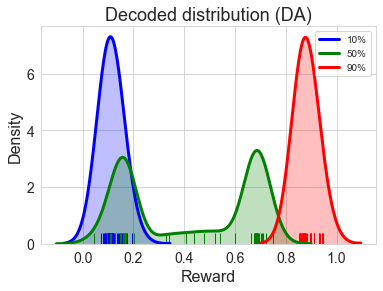

In [48]:
sns.kdeplot(da_decode_10, bw=.05, color='b', lw=3., shade=True, label="10%")
sns.rugplot(da_decode_10, color='b')

sns.kdeplot(da_decode_50, bw=.05, color='g', lw=3., shade=True, label="50%")
sns.rugplot(da_decode_50, color='g')

sns.kdeplot(da_decode_90, bw=.05, color='r', lw=3., shade=True, label="90%")
sns.rugplot(da_decode_90, color='r')

plt.tick_params(top=False, right=False, labelsize=14)
plt.xlabel("Reward", fontsize=16)
plt.ylabel("Density", fontsize=16)
_ = plt.title("Decoded distribution (DA)", fontsize=18)

In [49]:
# Decoding from dopamine neurons
ga_decode_10, fvl = run_decoding(
    ga_data[:, 0], est_tau_ga, minv=0.0, maxv=1.,
    max_epochs=3, N=20, max_samples=20000, method='TNC')

ga_decode_50, fvl = run_decoding(
    ga_data[:, 1], est_tau_ga, minv=0.0, maxv=1.,
    max_epochs=3, N=20, max_samples=20000, method='TNC')

ga_decode_90, fvl = run_decoding(
    ga_data[:, 2], est_tau_ga, minv=0.0, maxv=1.,
    max_epochs=3, N=20, max_samples=20000, method='TNC')


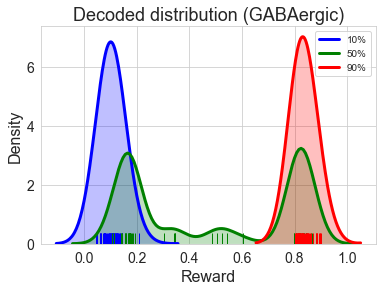

In [50]:
sns.kdeplot(ga_decode_10, bw=.05, color='b', lw=3., shade=True, label="10%")
sns.rugplot(ga_decode_10, color='b')

sns.kdeplot(ga_decode_50, bw=.05, color='g', lw=3., shade=True, label="50%")
sns.rugplot(ga_decode_50, color='g')

sns.kdeplot(ga_decode_90, bw=.05, color='r', lw=3., shade=True, label="90%")
sns.rugplot(ga_decode_90, color='r')

plt.tick_params(top=False, right=False, labelsize=14)
plt.xlabel("Reward", fontsize=16)
plt.ylabel("Density", fontsize=16)
_ = plt.title("Decoded distribution (GABAergic)", fontsize=18)

## Sensitivity of decoding loss to Bernoulli reference distributions

In [51]:
n_trials = 100
n_samples = 2000
bern_param = np.linspace(0., 1., 100)
bern_scores = np.zeros((len(bern_param), n_trials, 3))

for i in range(len(bern_param)):
  p = bern_param[i]
  for t in range(n_trials):
    for j in range(3):
      # Generate samples from Bernoulli distribution with parameter p
      ref_samples = (np.random.random(n_samples) < p).astype(np.float32)
      bern_scores[i, t, j] = expectile_loss_fn(
          da_data[:, j], est_tau_da, ref_samples)


In [52]:
# Repeat the analysis for the GABA-ergic recordings
ga_bern_scores = np.zeros((len(bern_param), n_trials, 3))
for i in range(len(bern_param)):
  p = bern_param[i]
  for t in range(n_trials):
    for j in range(3):
      # Generate samples from Bernoulli distribution with parameter p
      ref_samples = (np.random.random(n_samples) < p).astype(np.float32)
      ga_bern_scores[i, t, j] = expectile_loss_fn(
          ga_data[:, j], est_tau_ga, ref_samples)

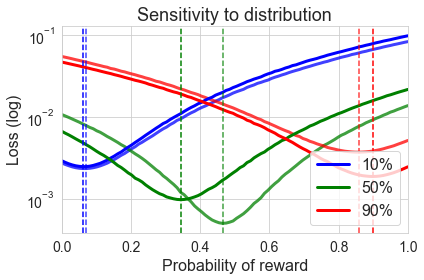

In [53]:
fig = plt.figure()

plt.plot(bern_param, ga_bern_scores.mean(1)[:, 0], color='b', lw=3., alpha=0.75)
plt.plot(bern_param, ga_bern_scores.mean(1)[:, 1], color='g', lw=3., alpha=0.75)
plt.plot(bern_param, ga_bern_scores.mean(1)[:, 2], color='r', lw=3., alpha=0.75)

plt.plot(bern_param, bern_scores.mean(1)[:, 0], color='b', lw=3., label="10%")
plt.plot(bern_param, bern_scores.mean(1)[:, 1], color='g', lw=3., label="50%")
plt.plot(bern_param, bern_scores.mean(1)[:, 2], color='r', lw=3., label="90%")

plt.axvline(bern_param[ga_bern_scores.mean(1)[:, 0].argmin()], color='b', linestyle='--', alpha=0.75)
plt.axvline(bern_param[ga_bern_scores.mean(1)[:, 1].argmin()], color='g', linestyle='--', alpha=0.75)
plt.axvline(bern_param[ga_bern_scores.mean(1)[:, 2].argmin()], color='r', linestyle='--', alpha=0.75)

plt.axvline(bern_param[bern_scores.mean(1)[:, 0].argmin()], color='b', linestyle='--')
plt.axvline(bern_param[bern_scores.mean(1)[:, 1].argmin()], color='g', linestyle='--')
plt.axvline(bern_param[bern_scores.mean(1)[:, 2].argmin()], color='r', linestyle='--')

# We show the log-loss to emphasize values near the solution.
plt.yscale('log')

plt.xlim([0., 1.])
plt.tick_params(top=False, right=False, labelsize=14)
plt.legend(loc='best', fontsize=16)
plt.ylabel("Loss (log)", fontsize=16)
plt.xlabel("Probability of reward", fontsize=16)
plt.title("Sensitivity to distribution", fontsize=18)

plt.tight_layout()